## **RADI605: Modern Machine Learning**

### Assignment: Convolutional Neural Networks
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

In [1]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from pathlib import Path
import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score, roc_curve
from collections import Counter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings 
warnings.filterwarnings('ignore')

### Data Exploration: Baseline Characteristics

Prior to modeling, it is vital that we evaluate the characteristics of the datasets to conduct appropriate preprocessing tasks. The original dataset consists of 9796 images, distributed from 6877 training images, 1622 testing images, and 1297 validation. We checked the list of labels and have found out that 1690 training images does not have the corresponding labels. Therefore, **we will not include these images in our training dataset.** 

Future considerations may apply if the user wants to adopt a semi-supervised learning that uses both labeled and unlabeled datasets. In this task, however, will use a supervised learning for simplicity.

In [27]:
label_path = 'D:/nodule/data/labels/'

label = [pd.DataFrame(pd.read_csv(os.path.join(label_path, file), delim_whitespace = True)) for file in os.listdir(label_path)]
df = pd.concat(label, ignore_index = True)
df['types'] = [string.split('/') for string in df['image']]
df['types'] = [string[0] for string in df['types']]
df['image'] = [string.split('/') for string in df['image']]
df['image'] = [string[1][6:-4] for string in df['image']]

dict = {}
image_path = 'D:/nodule/data/images/'
folders = os.listdir(image_path)
images = ([os.listdir(os.path.join(image_path, folder)) for folder in folders])
test_images, train_images, valid_images  = images[0], images[1], images[2]

We created a <code>NoduleDataset</code> class that represents the nodule images, including training, validation, and testing sets. These images can inherit the <code>Dataset</code> module and override the following methods:
- <code>__len__</code> function that returns the size of the dataset
- <code>__getitem__</code> function that supports the indexing of an $i$ image. 

We added a new function called <code>_load_data</code> that calls all the labels of the images. This function preprocess the label dataset and returns an array of the image and its binary label (i.e., either 0 for benign or 1 as malignant). The <code>NoduleDataset</code> class needs the following arguments: <code>data_path</code>, <code>image_path</code>, and <code>transforms</code>. 

Note: You may also access the <code>NoduleDataset</code> either the Python file <code>data_loader.py</code> or by importing it as <code>from data_loader import NoduleDataset</code>.

In [58]:
class NoduleDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, image_path, transforms = None):    
        ''' 
        Arguments:
             data_path (string): Directory of all the datasets
            image_path (string): Path to the image files. It should be either train, val, or test
            transform  (callable, option): Optional transfrom to be applied on an image for data augmentation
        '''
        self.transform  = transforms
        self.data_path  = data_path
        self.images_dir = data_path / 'images' / Path(image_path)

        if   image_path == 'train': 
            self.labels_dir = data_path / 'labels' / 'trainlabels.txt'
        elif image_path == 'val':
            self.labels_dir = data_path / 'labels' / 'vallabels.txt'
        elif image_path == 'test' :
            self.labels_dir = data_path / 'labels' / 'testlabels.txt'
        self.dataset = self._load_data(self.images_dir, self.labels_dir)

    def __getitem__(self, index):
        dataset  = self.dataset
        img_path = self.images_dir / dataset[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = dataset[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset) 

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data

One issue we can see from our image datasets is that the samples have small sizes and varying variation in terms of brightness and contrast. Most neural networks expect the images of a fixed, large size with varying degree of transformations. Hence, we need to write some processing code to perform image processing and make it suitable for CNN training. In addition, we need to use data augmentation techniques using transformation in our training process to artificially create new samples of our data, and use some constant preprocessing in the validation and testing case. This can provide generability in our datasets since augmentation acts as a regularizer and assists in managing the overfitting the data by exposing our CNN model to different versions of the images.  

In <code>PyTorch</code>, the widely-used image transformations are available in the <code>torchvision.transforms</code> module. They can be chained together using <code>Compose</code>. The appropriate transformations needed in our task and nodule image datasets are the following:
1. <code>Resize</code>: Resize the image shape. We checked some images and it has a size of <code>50 x 50</code> height and width. We need to assure that all images are of the same size. Therefore, resize is important.
2. <code>ToTensor</code>: We need to convert the image into PyTorch tensor shapes prior it into the CNN model. The image tensor shape should correspond to <code>(N, C, H, W)</code> representing the batch size, channels, height, and width, respectively.
3. <code>Normalize</code>: We need to normalize the image using the generally accepted values of mean $\mu = [0.485, 0.456, 0.406]$ and standard deviation $\sigma = [0.229, 0.224, 0.225]$ to convert the RGB channels of values [0, 255] into range [0, 1]. These $\mu$ and $\sigma$ were obtained by PyTorch using the <code>ImageNet</code> images. 
4. <code>RandomRotation</code>: This transformation rotates the image by a given angle. RandomRotation is a useful agumentation since it changes the angles that tissues appear in the given dataset during training. It can improve the generability of the dataset since some image collection processes vary. For instance, the images may only be collected with a nodule horizontally, but in reality, the nodule could be skewed in either direction. Therefore, random rotation can improve the model without collecting and (manually) labeling more data.
5. <code>RandomCrop</code>: This is a data augmentation technique where we create a random subset of the original image. Our primary task is to detect whether an image has a nodule. We have images when a nodule is visible but the nodules may not always complete in one frame, nor are they constantly in the same size. Therefore, RandomCrop can be a great choice as an augmentation technique in nodule classification task to recognize images with nodules, especially those nodules that are not always completely in frame. 
6. <code>RandomHorizontalFlip</code>.

As you can see in the code below, there are different transformations applied to training and validation datasets.
The <code>train_transform</code> has some random transforms, e.g., <code>RandomRotation</code>, which is fine for training but can yield different predictions for the same image in our testing dataset. It is thus preferred to use the non-random versions of the transformations for the validation to get consistent predictions.

In [59]:
train_transform =   transforms.Compose([
                    transforms.RandomRotation(10),      
                    transforms.RandomHorizontalFlip(),  
                    transforms.Resize((50)), 
                    transforms.RandomCrop(32, padding = 2),         
                    transforms.CenterCrop(40),         
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

valid_transform =   transforms.Compose([
                    transforms.Resize((50)),
                    transforms.CenterCrop(40),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

data_path  = Path('D:/nodule/data/')
train_dataset  = NoduleDataset(data_path, image_path = 'train', transforms = train_transform)
valid_dataset  = NoduleDataset(data_path, image_path = 'val',   transforms = valid_transform)
test_dataset   = NoduleDataset(data_path, image_path = 'test',  transforms = valid_transform)

Our initial analysis during data exploration is that the given dataset is imbalanced. That is, the number of images without nodules are higher than the images with nodules. In the training dataset, there are 4342 images with label 0 while only 845 images have label 1, accounting to 83.71\% and 16.29\%. The same case also exists in our validation dataset with with 1073 images without nodules while the remaining 224 have nodules. Imbalanced data brings challenges to feature correlation, class separation and evaluation, and mostly results in poor model performance.

To rectify data imbalanced, we utilized <code>WeightedRandomSampler</code> for both training and validation sets. This function expects a <code>weight</code> tensor that assigns a weight to each image and ensures that each batch of images sees a proportional number of all classes. We created a function called <code>get_sampler</code> that uses WeightedRandomSampler and returns the appropriate sampling proportion of each class for every dataset. The sampler should consists of the weights for each target sample.

The datasets and samplers are then fed into the <code>DataLoader</code>. Using the PyTorch dataset and managing it with the DataLoader keeps our data manageable and helps to simplify our deep learning pipeline. The <code>Dataset</code> stores our data and the <code>DataLoader</code> can be used to iterate through the data. 

Our training and validation datasets consist of thousands of images. Our device may not be able to handle such large volumes of data during CNN training. Therefore, we use a <code>batch_size</code> of 32 as a hyperparameter to specify the number of samples being fed into the CNN model beforoe the model parameters are updated. In this way, our device is not overloaded with work and our model can learn very well.

In [60]:
def get_sampler(dataset):
    classes = [label for _,   label in dataset]
    index_0 = [idx   for idx, label in enumerate(classes) if label == 0]
    index_1 = [idx   for idx, label in enumerate(classes) if label == 1]
    weights = torch.zeros(len(index_0) + len(index_1))
    weights[index_0] = 1.0 / len(index_0)
    weights[index_1] = 1.0 / len(index_1)
    sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)
    return sampler

torch.manual_seed(42)
train_sampler = get_sampler(train_dataset)
valid_sampler = get_sampler(valid_dataset)

train_loader   = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
valid_loader   = DataLoader(valid_dataset, batch_size = 32, sampler = valid_sampler)
test_loader    = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

Let's display a batch of images to verify that the training loader selects nodule and without nodule images at random.

In [48]:
for images, labels in train_loader:
    break
class_names = ['B', 'M']
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

Label: [0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1]
Class:  B M M M M M B M M M M M B M B M M M M B M M M M B M M B M M M M


### CNN Model Formulation

We created our proposed model in a class called <code>SamuelNet</code>. This model takes an input size of $50 \times 50$ tensors and our output represents the 2 possible digits - either 0 or 1. We used AlexNet architecture as the baseline model for the nodule classification. However, we modified the baseline model in terms of the feature extractions and classifiers. 

We changed the AlexNet's feature extraction layers from five (5) to two (2) convolutions in order to reduce model complexity and avoid overfitting. These convolution layers takes three kernel filters with 1 stride and a single padding. Each convolution is followed by a max-pooling later. The output of the convolution layers is fed to the ReLU function to avoid overfitting. We added Batch Normalization layers to each convolution layers to help <code>SamuelNet</code> learn faster and reduce the internal covariate shift, which can slow down the training process. The Batch Normalization can also improve the generalization of our network since it can reduce the dependence on the initial weight initialization and the choice of hyperparameters.

Meanwhile, the <code>SamuelNet</code>'s classifier uses three fully-connected (FC) layers. However, we modified the third FC layer from the baseline model with 2 channels to classify 2 classes, instead of the regular 10 classes.

We also added dropouts in our model to improve generalization. 

In [55]:
class SamuelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32,   2)
        
        self.dropout = nn.Dropout(p = 0.2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Before we start the CNN model training, we created a function called <code>train</code> that simulates the whole training, validation, and testing process. This function requires the number of epochs <code>num_epochs</code>, CNN model <code>model</code>, the split datasets <code>train_loader, valid_loader</code>, and <code>test_loader</code>, optimization functions <code>optimizer, criterion, device</code>. The function <code>train</code> returns the losses, accuracy, metrics for training, validation, and testing. 

In [61]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct       = (rounded_preds == y).float()
    acc           = correct.sum() / len(correct)
    return acc

def get_metrics(prediction, label):
    prediction  = prediction.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    
    tp = np.sum((prediction == 1) & (label == 1))
    tn = np.sum((prediction == 0) & (label == 0))
    fp = np.sum((prediction == 1) & (label == 0))
    fn = np.sum((prediction == 0) & (label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    try:
        auc = roc_auc_score(label, prediction)
    except ValueError:
        auc = None
    fpr, tpr, _ = roc_curve(label, prediction)
    return {'sensitivity': sensitivity,
            'specificity': specificity,
            'auc': auc,
            'fpr': fpr,
            'tpr': tpr}

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    train_metric, valid_metric = [], []

    epoch_times = []
    list_best_epochs = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_accu, train_metr = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, valid_metr = _evals(model, valid_loader, criterion, device)

        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        train_metric.append(train_metr)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        valid_metric.append(valid_metr)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_metric  = _evals(best_model, test_loader, criterion, device)
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric

def _train(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_train_loss = 0
    epoch_train_accu = 0

    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        accuracy = binary_accuracy(outputs, labels)
        metric   = get_metrics(outputs, labels)
        epoch_train_accu += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader) 
    epoch_train_accu = epoch_train_accu / len(train_loader) 
    return epoch_train_loss, epoch_train_accu, metric

def _evals(model, valid_loader, criterion, device):
    model.eval()
    epoch_valid_loss = 0
    epoch_valid_accu = 0

    all_predictions = []

    with torch.no_grad():
        for id, data in enumerate(valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            all_predictions.extend(outputs)

            epoch_valid_loss += loss.item()
            accuracy = binary_accuracy(outputs, labels)
            metric  = get_metrics(outputs, labels)
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accu = epoch_valid_accu / len(valid_loader)
    return epoch_valid_loss, epoch_valid_accu, metric

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(train_losses, label = 'Train')
    ax1.plot(valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(train_accurs, label='Train')
    ax2.plot(valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

class EarlyStopping:
  def __init__(self, patience  = 1, delta = 0, path = 'checkpoint.pt'):
    self.patience = patience
    self.delta = delta
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
     torch.save(model.state_dict(), self.path)

### Using a Pre-trained CNN model

Torchvision has a repository of state-of-the-art (SOTA) models available through their module <code>torchvision.models</code>, such as AlexNet, VGG, ResNet, SqueezeNet, and many more. They have all been trained on the <code>ImageNet</code> dataset. Our nodule classification task is to reduce the output of the fully-connected layers from 1000 classes to just 2 classes. We can instantiate the model by calling its constructor <code>torchvision.models.alexnet(pretrained = True)</code>.

We need to freeze the pre-trained weight and biases. We set <code>.requires_grad</code> to False so we don't backpropagate through them. We also need to modify the fully connected laters to produce a binary output. This section in the pre-trained model is labeled as a classifier.

In [67]:
model_alexnet = models.alexnet(pretrained = True)

for param in model_alexnet.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_alexnet.features[0] = torch.nn.Conv2d(3,  64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[2] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
model_alexnet.features[3] = torch.nn.Conv2d(64, 192, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[5] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

model_alexnet.classifier[6] = torch.nn.Linear(4096, 2)
model_alexnet.classifier[6].requires_grad = True

In [7]:
torch.manual_seed(42)
model_vgg19 = torchvision.models.vgg19(weights = True).to(device)
model_vgg19.classifier[-1] = torch.nn.Linear(4096, 2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg19.parameters(), lr = 1e-2, eps = 10e-06)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(2, model_vgg19, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 15.7254   	 Accuracy: 0.83666 	 Validation Loss  82.79232 	 Accuracy: 0.17208
Epoch: 2 	 Training: Loss 16.21933   	 Accuracy: 0.83781 	 Validation Loss  82.72507 	 Accuracy: 0.17275
Final Best Model from Best Epoch 1 Test Loss = 82.66488408107384, Test Acc = 0.17335115869839987


In [66]:
model_alexnet = models.alexnet(pretrained = True)

for param in model_alexnet.parameters():
    param.requires_grad = False

model_alexnet.features[0] = torch.nn.Conv2d(3,  64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[2] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
model_alexnet.features[3] = torch.nn.Conv2d(64, 192, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[5] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

model_alexnet.classifier[6] = torch.nn.Linear(4096, 2)
model_alexnet.classifier[6].requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_alexnet.classifier.parameters(), lr = 0.001, eps = 10e-06)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric = train(2, model_alexnet, train_loader, valid_loader, test_loader, optimizer, criterion, device)

In [173]:
class SAMUELNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(SAMUELNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 11, stride = 4, padding = 5),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 3, stride = 2),

            nn.Conv2d(32, 64, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            # nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
            # nn.ReLU(inplace = True),
            # nn.BatchNorm2d(32),

            # nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            # nn.ReLU(inplace = True),
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        self.classifier1 = nn.Linear(256, 32)
        self.classifier2 = nn.Linear(32, 32)
        self.classifier3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.classifier1(x))
        x = self.dropout(x)
        x = self.relu(self.classifier2(x))
        x = self.relu(self.classifier3(x))
        return x

torch.manual_seed(101)
model_cnn = SAMUELNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.0000001, weight_decay = 1e-5)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.69147   	 Accuracy: 0.50332 	 Validation Loss  0.69212 	 Accuracy: 0.4909
Epoch: 2 	 Training: Loss 0.69306   	 Accuracy: 0.4876 	 Validation Loss  0.69194 	 Accuracy: 0.48032
Epoch: 3 	 Training: Loss 0.69209   	 Accuracy: 0.49508 	 Validation Loss  0.69054 	 Accuracy: 0.47736
Epoch: 4 	 Training: Loss 0.69115   	 Accuracy: 0.50089 	 Validation Loss  0.68728 	 Accuracy: 0.5191
Epoch: 5 	 Training: Loss 0.69134   	 Accuracy: 0.50026 	 Validation Loss  0.6865 	 Accuracy: 0.49565
Epoch: 6 	 Training: Loss 0.69177   	 Accuracy: 0.49265 	 Validation Loss  0.6869 	 Accuracy: 0.51654
Epoch: 7 	 Training: Loss 0.69031   	 Accuracy: 0.50613 	 Validation Loss  0.69021 	 Accuracy: 0.47642
Epoch: 8 	 Training: Loss 0.69108   	 Accuracy: 0.4938 	 Validation Loss  0.68675 	 Accuracy: 0.51672
Epoch: 9 	 Training: Loss 0.6913   	 Accuracy: 0.50313 	 Validation Loss  0.68611 	 Accuracy: 0.50731
Epoch: 10 	 Training: Loss 0.69017   	 Accuracy: 0.49361 	 Validation Loss  0.68

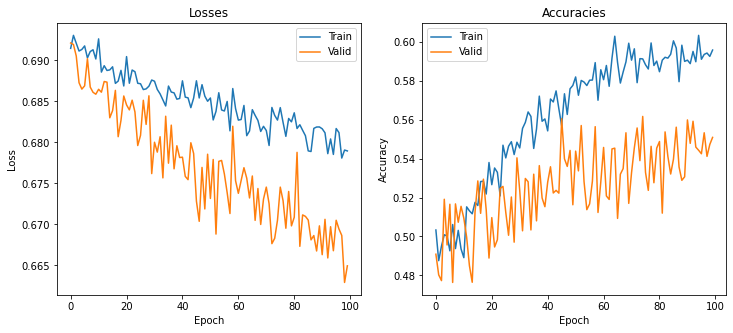

In [174]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

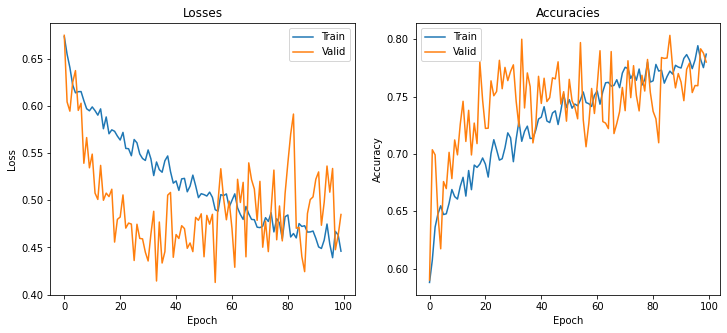

In [48]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

In [13]:
class SamuelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32,   2)

        self.dropout = nn.Dropout(p = 0.2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


torch.manual_seed(101)
model_cnn = SamuelNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.66989   	 Accuracy: 0.59062 	 Validation Loss  0.56607 	 Accuracy: 0.67992
Epoch: 2 	 Training: Loss 0.65139   	 Accuracy: 0.6227 	 Validation Loss  0.55434 	 Accuracy: 0.71243
Epoch: 3 	 Training: Loss 0.62471   	 Accuracy: 0.6482 	 Validation Loss  0.59503 	 Accuracy: 0.67813
Epoch: 4 	 Training: Loss 0.60908   	 Accuracy: 0.66194 	 Validation Loss  0.56858 	 Accuracy: 0.6866
Epoch: 5 	 Training: Loss 0.58753   	 Accuracy: 0.68079 	 Validation Loss  0.59216 	 Accuracy: 0.70319
Epoch: 6 	 Training: Loss 0.58564   	 Accuracy: 0.68232 	 Validation Loss  0.50476 	 Accuracy: 0.75018
Epoch: 7 	 Training: Loss 0.56554   	 Accuracy: 0.6921 	 Validation Loss  0.53953 	 Accuracy: 0.71539
Epoch: 8 	 Training: Loss 0.57628   	 Accuracy: 0.69268 	 Validation Loss  0.53735 	 Accuracy: 0.71471
Epoch: 9 	 Training: Loss 0.56392   	 Accuracy: 0.69919 	 Validation Loss  0.53896 	 Accuracy: 0.71225
Epoch: 10 	 Training: Loss 0.54994   	 Accuracy: 0.69772 	 Validation Loss  0

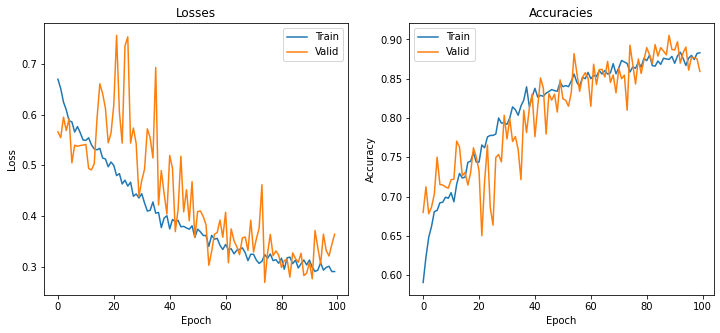

In [177]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

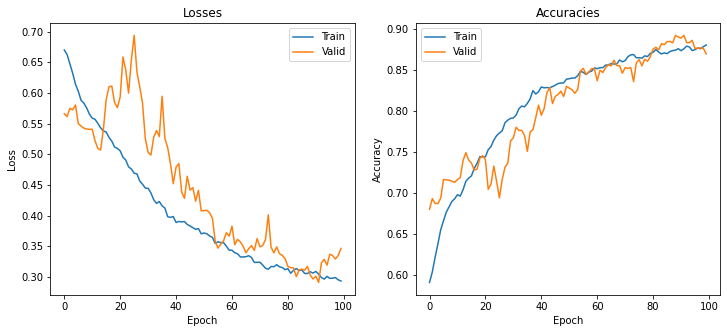

In [15]:
import pandas as pd
import numpy as np

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs, alpha = 0):
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs, alpha = 0.4)

In [167]:
class SAMNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32,  2)

        self.dropout = nn.Dropout(p = 0.3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


torch.manual_seed(101)
model_cnn = SAMNetwork()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.00001, weight_decay = 1e-6)
optimizer = torch.optim.SGD (model_cnn.parameters(), lr = 0.0001,  momentum = 0.9)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.68689   	 Accuracy: 0.56531 	 Validation Loss  0.68112 	 Accuracy: 0.62298
Epoch: 2 	 Training: Loss 0.67997   	 Accuracy: 0.58602 	 Validation Loss  0.67331 	 Accuracy: 0.63841
Epoch: 3 	 Training: Loss 0.66932   	 Accuracy: 0.60244 	 Validation Loss  0.66137 	 Accuracy: 0.66203
Epoch: 4 	 Training: Loss 0.66906   	 Accuracy: 0.59394 	 Validation Loss  0.65241 	 Accuracy: 0.68575
Epoch: 5 	 Training: Loss 0.6658   	 Accuracy: 0.60282 	 Validation Loss  0.65469 	 Accuracy: 0.65042
Epoch: 6 	 Training: Loss 0.66117   	 Accuracy: 0.61407 	 Validation Loss  0.6473 	 Accuracy: 0.65441
Epoch: 7 	 Training: Loss 0.65481   	 Accuracy: 0.6243 	 Validation Loss  0.64347 	 Accuracy: 0.65325
Epoch: 8 	 Training: Loss 0.65747   	 Accuracy: 0.61695 	 Validation Loss  0.63909 	 Accuracy: 0.66786
Epoch: 9 	 Training: Loss 0.65224   	 Accuracy: 0.61714 	 Validation Loss  0.63608 	 Accuracy: 0.65916
Epoch: 10 	 Training: Loss 0.64812   	 Accuracy: 0.62372 	 Validation Loss  

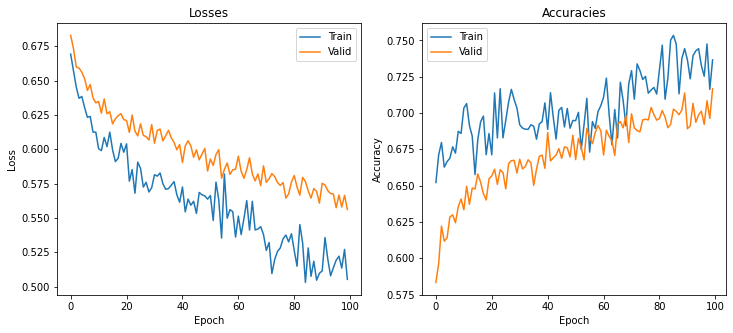

In [164]:
plot_metrics(valid_losses, train_losses, valid_accurs, train_accurs)

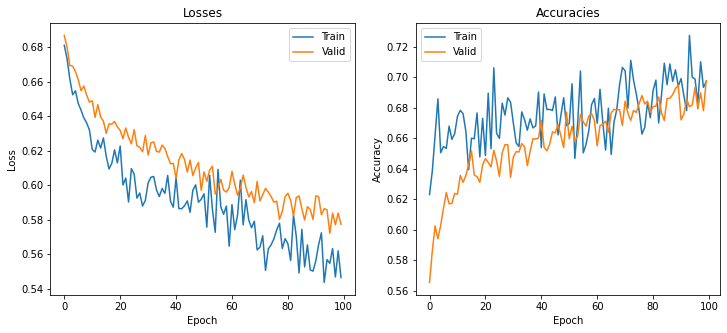

In [168]:
plot_metrics(valid_losses, train_losses, valid_accurs, train_accurs)